In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import json
import re
import string
import nltk
# nltk.download('stopwords')
# nltk.download('words')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

from tqdm import tqdm
import joblib

In [2]:
def preprocess_text(text, stem=False):
    text = text.lower()
    # delete special characters
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)
    # delete links
    text = re.sub(r'http\S+', '', text)
    # delete multispaces
    text = re.sub('\s\s+', ' ', text)
    # delete digits
    text = re.sub(r'[0-9]+', '', text)
    # delete stop words
    text = text.split(' ')
    text = ' '.join([word for word in text if not word in STOPWORDS])
    
    text = remove_stopwords(text)
    if stem:
        stem = SnowballStemmer(language='english')
        text = ' '.join([stem.stem(word) for word in text.split(' ')])
    else:
        lemmatizer = WordNetLemmatizer()
        text = ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])
    text = text.strip()
    return text

In [3]:
import os.path

if not os.path.isfile('yelp_review_nostop_punc_engOnly_lem.csv') :
    yelp = pd.read_csv('yelp_review.csv')
    if 'Unnamed: 0' in yelp.columns:
        yelp = yelp.drop('Unnamed: 0', axis=1)
    for i in tqdm(range(len(yelp))):
        yelp.loc[i,'text']  = preprocess_text(yelp.loc[i,'text'], stem=False)
    yelp.to_csv('yelp_review_nostop_punc_engOnly_lem.csv')

In [4]:
# 'yelp_review_nostop_punc_engOnly.csv' is using SnowballStemmer
# 'yelp_review_nostop_punc_engOnly_lem.csv' is using WordNetLemmatizer

yelp = pd.read_csv('yelp_review_nostop_punc_engOnly_lem.csv')

In [5]:
import random
from random import sample

random.seed(5)

corpus = sample(yelp["text"].apply(str).to_list(), 50000)
# corpus = yelp["text"].apply(str).to_list()

In [6]:
vectorizer = TfidfVectorizer(
    max_df=0.5,
    min_df=5,
    stop_words="english",
    )
X_tfidf = vectorizer.fit_transform(corpus)
X_tfidf.shape
# 26s

(50000, 15449)

In [7]:
tf_idf = pd.DataFrame(data = X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)

50000 rows


,0,1,2,3,4,5,6,7,8,9,...,49990,49991,49992,49993,49994,49995,49996,49997,49998,49999
quiet,0.251073,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
little,0.250268,0.0,0.0,0.000000,0.0,0.118622,0.0,0.036499,0.0,0.0,...,0.044041,0.164711,0.068651,0.0,0.0,0.032795,0.000000,0.0,0.0,0.0
play,0.246206,0.0,0.0,0.106731,0.0,0.000000,0.0,0.071814,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0
tucson,0.244286,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.166567,0.0,0.0,0.0
guacamole,0.242367,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0


In [8]:
print(f"We find that around {X_tfidf.nnz / np.prod(X_tfidf.shape) * 100:.3f}% of the entries of the X_tfidf matrix are non-zero.")

We find that around 0.306% of the entries of the X_tfidf matrix are non-zero.


In [9]:
from sklearn.cluster import KMeans

def fit_diff_n_clusters_and_evaluation(X_tfidf, n_clusters: list):
    evaluation = pd.DataFrame(columns=["n_clusters", "Sum of Squared Distance", 
                                       "Davies-Bouldin Score", "Silhouette Coefficient"])
    for n_c in n_clusters:
        kmeans = KMeans(
            n_clusters=n_c,
            max_iter=100,
            n_init=5,
        )
        kmeans.set_params(random_state=42)
        kmeans.fit(X_tfidf)
        db_score = metrics.davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
        silhouette_score = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_, sample_size=2000)
        evaluation.loc[len(evaluation),] = [n_c, kmeans.inertia_, db_score, silhouette_score]
    return evaluation

In [10]:
silhouette_and_dbi = fit_diff_n_clusters_and_evaluation(X_tfidf, range(2, 20))
silhouette_and_dbi.to_csv('evaluation_scores.csv')  

In [11]:
from tqdm import tqdm
def get_ssd(X_tfidf, n_clusters: list):
    evaluation = pd.DataFrame(columns=["n_clusters", "Sum of Squared Distance", 
                                       "Davies-Bouldin Score", "Silhouette Coefficient"])
    for n_c in tqdm(n_clusters):
        kmeans = KMeans(
            n_clusters=n_c,
            max_iter=100,
            n_init=5,
        )
        kmeans.set_params(random_state=42)
        kmeans.fit(X_tfidf)
#         db_score = metrics.davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
#         silhouette_score = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_, sample_size=2000)
        evaluation.loc[len(evaluation),] = [n_c, kmeans.inertia_, 0, 0]
    return evaluation

ssd = get_ssd(X_tfidf, range(2, 150))

100%|███████████████████████████████████████| 148/148 [1:04:29<00:00, 26.15s/it]


In [12]:
from sklearn.cluster import AgglomerativeClustering


def fit_diff_n_clusters_and_evaluation_agg(X_tfidf, n_clusters: list):
    evaluation = pd.DataFrame(columns=["n_clusters", "Davies-Bouldin Score", "Silhouette Coefficient"])
    for n_c in n_clusters:
        agg = AgglomerativeClustering(distance_threshold=0, n_clusters=n_c)
        agg.set_params(random_state=42)
        agg.fit(X_tfidf)
        db_score = metrics.davies_bouldin_score(X_tfidf.toarray(), kmeans.labels_)
        silhouette_score = metrics.silhouette_score(X_tfidf.toarray(), kmeans.labels_, sample_size=2000)
        evaluation.loc[len(evaluation),] = [n_c, db_score, silhouette_score]
    return evaluation

In [13]:
ssd.to_csv('sumofSquaredDistance.csv')  

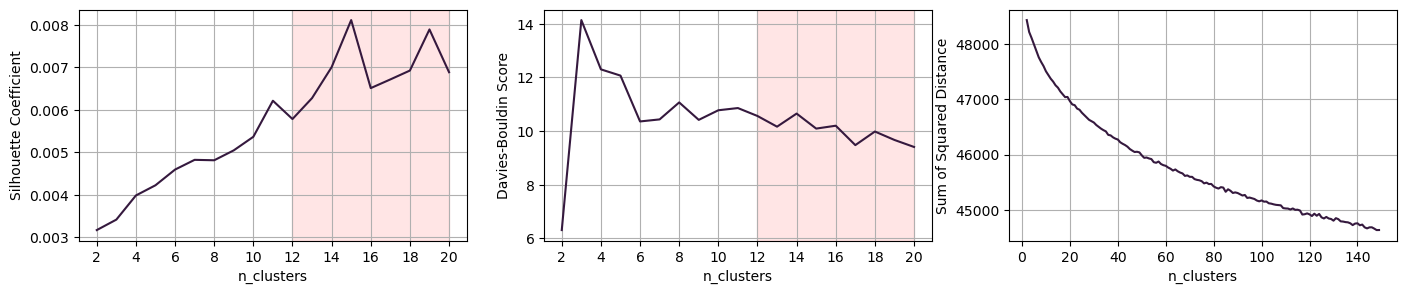

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

scores = pd.read_csv('evaluation_scores.csv', index_col=0)
# plt.plot(scores.n_clusters, scores["Silhouette Coefficient"])

markers_on = [8]
plt.figure(figsize=(17,3))

plt.subplot(1, 3, 1)
sns.lineplot(x = "n_clusters", y = "Silhouette Coefficient",data=scores)
sns.set_palette("rocket")
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.axvspan(12, 20, color='red', alpha=0.1)
# plt.plot(marker="v", markevery=[8])
plt.grid()

plt.subplot(1, 3, 2)
sns.lineplot(x = "n_clusters", y = "Davies-Bouldin Score",data=scores)
sns.set_palette("rocket")
plt.xticks([2,4,6,8,10,12,14,16,18,20])
plt.axvspan(12, 20, color='red', alpha=0.1)
plt.grid()

plt.subplot(1, 3, 3)
sns.lineplot(x = "n_clusters", y = "Sum of Squared Distance",data=ssd)
sns.set_palette("rocket")

# plt.xticks([2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
# plt.xticks([2,4,6,8,10,12,14,16,18,20, 22, 24,26,28,30,32,34,36,38,40,42,44,46,48])
plt.grid()
plt.show()

In [15]:
kmeans = KMeans(
            n_clusters=10,
            max_iter=100,
            n_init=5,
        )
kmeans.set_params(random_state=42)
kmeans.fit(X_tfidf)

KMeans(max_iter=100, n_clusters=10, n_init=5, random_state=42)

In [16]:
clusters = kmeans.labels_
clusters

array([2, 0, 2, ..., 2, 0, 1], dtype=int32)

In [17]:
def get_top_keywords(X, n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(X_tfidf, 10)


Cluster 0
great,service,best,delicious,restaurant,like,time,good,place,food

Cluster 1
pancake,food,brunch,great,place,good,toast,egg,coffee,breakfast

Cluster 2
friendly,nice,beer,bar,drink,service,good,place,food,great

Cluster 3
bun,like,time,cheese,food,great,place,good,fry,burger

Cluster 4
time,pepperoni,topping,cheese,great,slice,place,good,crust,pizza

Cluster 5
didnt,ordered,server,service,came,time,minute,table,order,food

Cluster 6
food,fry,lunch,great,chicken,bread,place,cheese,good,sandwich

Cluster 7
time,fish,service,fresh,great,tuna,good,place,roll,sushi

Cluster 8
margarita,ordered,great,chip,place,food,good,mexican,salsa,taco

Cluster 9
spicy,dish,noodle,thai,sauce,food,rice,fried,good,chicken


In [18]:
kmeans = KMeans(
            n_clusters=15,
            max_iter=100,
            n_init=5,
        )
kmeans.set_params(random_state=42)
kmeans.fit(X_tfidf)
clusters = kmeans.labels_
get_top_keywords(X_tfidf, 10)


Cluster 0
best,good,like,flavor,coffee,chocolate,cake,place,glazed,donut

Cluster 1
friendly,mexican,price,like,time,restaurant,service,place,good,food

Cluster 2
bartender,hour,happy,food,great,place,good,drink,beer,bar

Cluster 3
food,good,curry,pad,soup,broth,ramen,pho,noodle,thai

Cluster 4
time,service,fish,great,fresh,tuna,good,place,roll,sushi

Cluster 5
food,fry,chicken,great,lunch,place,bread,cheese,good,sandwich

Cluster 6
food,meal,restaurant,delicious,dish,sauce,ordered,shrimp,salad,good

Cluster 7
wait,service,asked,said,came,time,table,food,order,minute

Cluster 8
love,amazing,atmosphere,staff,friendly,good,place,service,food,great

Cluster 9
time,pepperoni,great,topping,cheese,slice,place,good,crust,pizza

Cluster 10
best,delicious,im,food,love,good,like,coffee,time,place

Cluster 11
got,place,rice,hot,ordered,sauce,food,good,fried,chicken

Cluster 12
ordered,tortilla,great,chip,place,food,mexican,good,salsa,taco

Cluster 13
biscuit,bacon,place,pancake,good,brunch,coffe

In [20]:
kmeans = KMeans(
            n_clusters=20,
            max_iter=100,
            n_init=5,
        )
kmeans.set_params(random_state=42)
kmeans.fit(X_tfidf)
clusters = kmeans.labels_
get_top_keywords(X_tfidf, 10)


Cluster 0
dont,bar,location,im,love,food,good,like,time,place

Cluster 1
time,pepperoni,great,cheese,topping,slice,place,good,crust,pizza

Cluster 2
steak,menu,delicious,meal,restaurant,ordered,dinner,dish,good,salad

Cluster 3
place,meat,wing,rib,brisket,sauce,good,bbq,mac,cheese

Cluster 4
drink,menu,nice,place,food,good,great,selection,bar,beer

Cluster 5
nice,iced,love,breakfast,good,latte,great,place,shop,coffee

Cluster 6
staff,amazing,friendly,atmosphere,good,drink,place,service,food,great

Cluster 7
drink,service,asked,said,came,time,table,food,order,minute

Cluster 8
price,friendly,staff,like,time,restaurant,service,place,good,food

Cluster 9
food,place,bacon,good,biscuit,pancake,brunch,toast,egg,breakfast

Cluster 10
tortilla,pastor,ordered,fish,great,food,salsa,place,good,taco

Cluster 11
pho,soup,food,sauce,spicy,good,noodle,fried,rice,chicken

Cluster 12
ordered,food,place,crawfish,fried,good,seafood,crab,oyster,shrimp

Cluster 13
place,dish,good,chicken,restaurant,noodle